# Packages and lib imports

In [1]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

In [2]:
# imports

from src.deep.model_analyzer_src import ModelAnalyzer
from src.deep.models import *
from src.deep.trainers import Trainer
from src.general_methods.visualizer import Visualizer
from src.optics.config_manager import ConfigManager
import torchviz

from tqdm.notebook import tqdm
import os


# Parameters configuration

In [3]:
# configs
model_name = 'unet_v3_channel2_noiseless_c_big_ds_mu019_v1'
trained_model_path = '/data/yarcoh/thesis_data/data/test_models/'+model_name
main_ds_path = '/data/yarcoh/thesis_data/data/datasets/c/noiseless_big/30000samples_20mu'
ds_subdir = 'mu=0.19'
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/100000samples_20mu/'
# ds_subdir = '100000_samples_mu=0.200'
datasetpath = os.path.join(main_ds_path, ds_subdir)

# Init

In [4]:
# load trainer from file
trainer: Trainer = Trainer.load3(trained_model_path)

In [5]:
conf = trainer.train_dataset.config
conf.__dict__


{'W': 0.05,
 'Nspans': 12,
 'La': 80,
 'M_QAM': 16,
 'Ts': 1.0,
 'Nos': 16,
 'eta': 2,
 'mu': 0.19473684210526315,
 'bet': 0.2,
 'with_ssf': True,
 'with_noise': False,
 'beta2': -21.0,
 'gamma': 1.27,
 'dz': 0.2,
 'K_T': 1.13,
 'chi': 0.0461,
 'verbose': False,
 'io_type': 'c',
 'N_sc': 256,
 'T_guardband': 4750.0880922277665,
 'N_sc_raw': 237.50440461138834,
 'L': 960,
 'T0': 5120.0,
 'Tb': 10240.0,
 'Tn': 1358.1221810508403,
 'Zn': 87833.13612677579,
 'Pn': 8.964743939765935e-06,
 'Ns': 4096,
 'Nnft': 16384,
 'Tnft': 68266.66666666667,
 'dt': 4.166666666666667,
 'Nb': 2458,
 'T1': -25.132741228718345,
 'T2': 25.12967326714258,
 'XI': array([-511.9375,  512.    ])}

In [6]:
trainer.print_summary()

/home/yarcoh/projects/thesis-code4/src/deep/data_loaders.py:294: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/torch/csrc/utils/tensor_new.cpp:201.)
  t = torch.Tensor([np_vec.real, np_vec.imag])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 256]             224
              Tanh-2              [-1, 32, 256]               0
         MaxPool1d-3              [-1, 32, 128]               0
            Conv1d-4              [-1, 64, 128]           6,208
              Tanh-5              [-1, 64, 128]               0
         MaxPool1d-6               [-1, 64, 64]               0
            Conv1d-7              [-1, 128, 64]          24,704
              Tanh-8              [-1, 128, 64]               0
   ConvTranspose1d-9               [-1, 64, 64]          24,640
             Tanh-10               [-1, 64, 64]               0
  ConvTranspose1d-11              [-1, 32, 128]           4,128
             Tanh-12              [-1, 32, 128]               0
  ConvTranspose1d-13               [-1, 2, 256]             130
Total params: 60,034
Trainable params: 

saved model architecture to /data/yarcoh/thesis_data/data/test_models/unet_v3_channel2_noiseless_c_big_ds_mu019_v1/_analyze/architecture.png


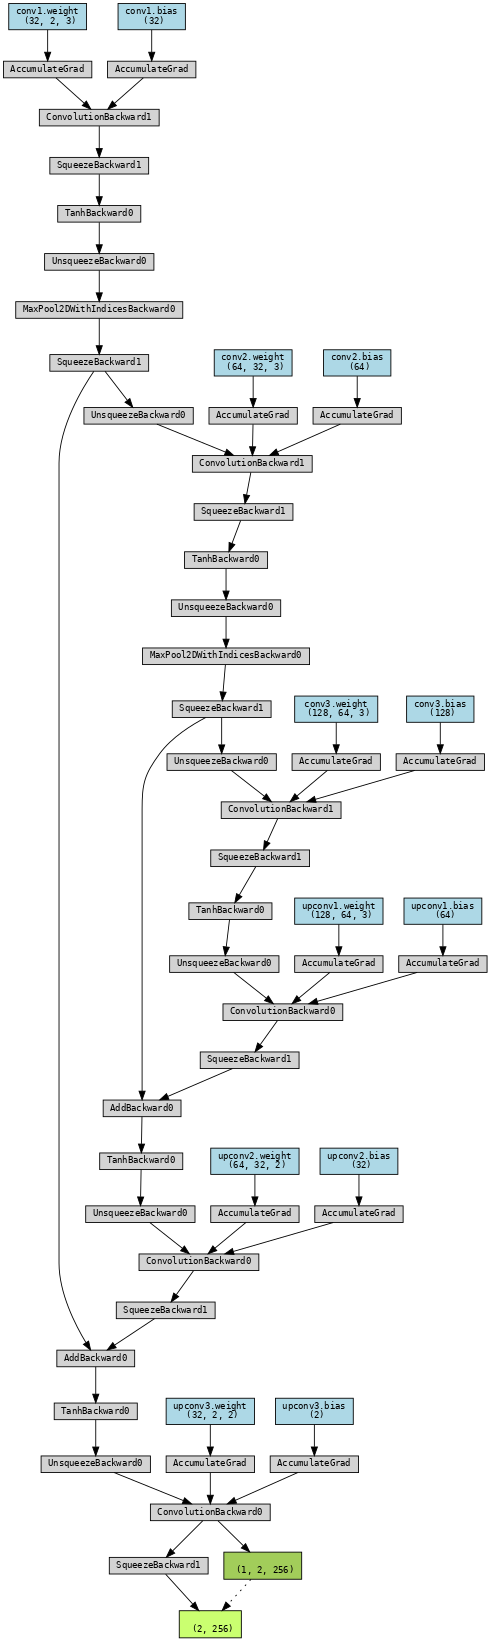

In [8]:
from IPython.display import Image
path = f'{trained_model_path}/_analyze/architecture'
trainer.plot_architecture(path)

# Replace 'image_path' with the path to your image file
Image(filename=path+'.png')


In [ ]:
# for broken models with old config
inp = input('Do you want to refresh config? (y/n) ')
if inp == 'y':
    trainer.train_dataset.config = ConfigManager.refresh_config(trainer.train_dataset.config)
    trainer.save(trained_model_path)
else:
        print('config not refreshed')

In [9]:
ma: ModelAnalyzer = ModelAnalyzer(trainer,model_name)

In [10]:
ma.load_test_dataset(datasetpath, train_ds_ratio=0.4, val_ds_ratio=0.3, test_ds_ratio=0.3)

In [11]:
print(len(trainer.val_dataset))

9000


In [ ]:
#pretty print ds config


# Visualizer.print_config(trainer.val_dataset.config)

# analyze 1 sample

In [12]:
print(ma.cs_in.channel_config.io_type)

c


In [ ]:
# ma.plot_single_item(1)
N = ma.cs_in.channel_config.Ns
N = ma.cs_in.channel_config.N_sc
ma.cs_in.channel_config.io_type
ma.plot_single_item_together(i=1, zm_indices=range(N//2,N//2+50))

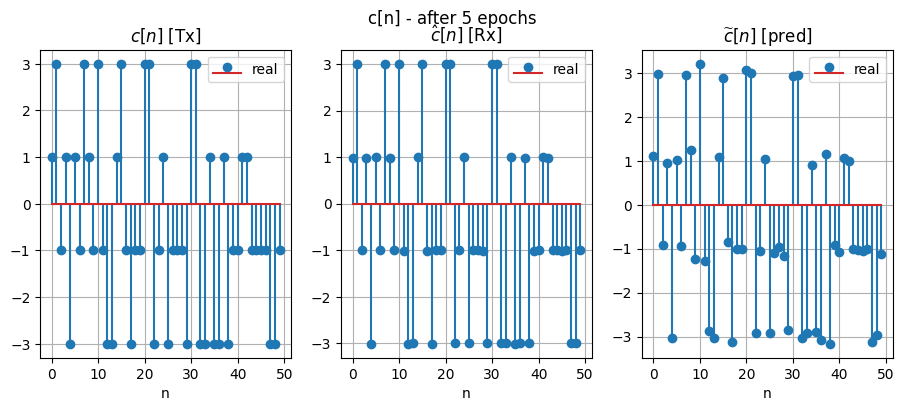

In [13]:
ma.plot_stems(i=1, zm_indices=range(0,50))

# analyze constelation

  0%|          | 0/40 [00:00<?, ?it/s]

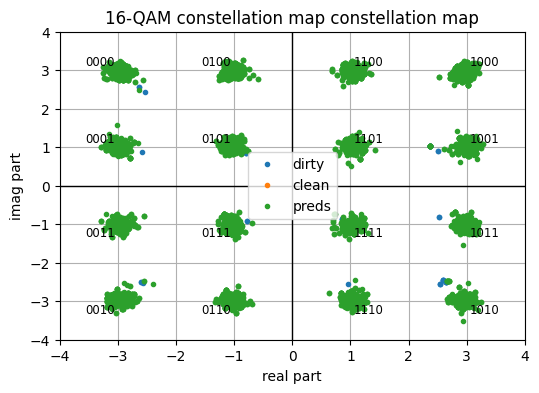

In [14]:
ma.plot_constelation(range(0,40))

In [15]:
x_power_i, y_power, pred_power = ma.calc_norms(_tqdm=tqdm, verbose_level=1, max_items=10000)
print(f'x_power: {x_power_i}\ny_power: {y_power}\npred_power: {pred_power}')

  0%|          | 0/9000 [00:00<?, ?it/s]

x_power: 2506.1746258138214
y_power: 2554.6764444444357
pred_power: 2544.3621774088356


In [ ]:
# ma.upload_single_item_plots_to_wandb(1)

In [16]:
ma.plot_bers(_tqdm=tqdm, verbose_level=1,num_x_per_folder=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

the original avg ber (of validation set) is 0.0


  0%|          | 0/1000 [00:00<?, ?it/s]

the trained avg ber (of validation set) is 0.0
the ber improvement is 0.00%


In [ ]:
ma.upload_bers_to_wandb()

# test all BERs

In [ ]:
# add powers

from apps.deep.power_adder import PowerAdder


main_ds_path = '/data/yarcoh/thesis_data/data/datasets/c/noiseless_big/30000samples_20mu'
power_adder = PowerAdder(is_overright=True, verbose_level=2)
power_adder.calculate_and_add_powers(main_ds_path)
# power_adder.replace_key_in_config_files(main_ds_path)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.100 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.150 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.190 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.240 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.290 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.340 | org_ber=4.23e-05 | model_ber=9.77e-06 |  ber_improve=077%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.380 | org_ber=1.80e-03 | model_ber=1.55e-03 |  ber_improve=014%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.430 | org_ber=9.26e-03 | model_ber=8.16e-03 |  ber_improve=012%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.480 | org_ber=3.28e-02 | model_ber=2.85e-02 |  ber_improve=013%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.530 | org_ber=7.23e-02 | model_ber=6.51e-02 |  ber_improve=010%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.570 | org_ber=1.16e-01 | model_ber=1.06e-01 |  ber_improve=009%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.620 | org_ber=1.67e-01 | model_ber=1.57e-01 |  ber_improve=006%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.670 | org_ber=2.12e-01 | model_ber=2.03e-01 |  ber_improve=004%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.720 | org_ber=2.45e-01 | model_ber=2.39e-01 |  ber_improve=003%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.760 | org_ber=2.77e-01 | model_ber=2.73e-01 |  ber_improve=002%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.810 | org_ber=3.03e-01 | model_ber=3.01e-01 |  ber_improve=001%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.860 | org_ber=3.20e-01 | model_ber=3.19e-01 |  ber_improve=000%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.910 | org_ber=3.39e-01 | model_ber=3.38e-01 |  ber_improve=000%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.950 | org_ber=3.53e-01 | model_ber=3.53e-01 |  ber_improve=000%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=1.000 | org_ber=3.61e-01 | model_ber=3.62e-01 |  ber_improve=-00%


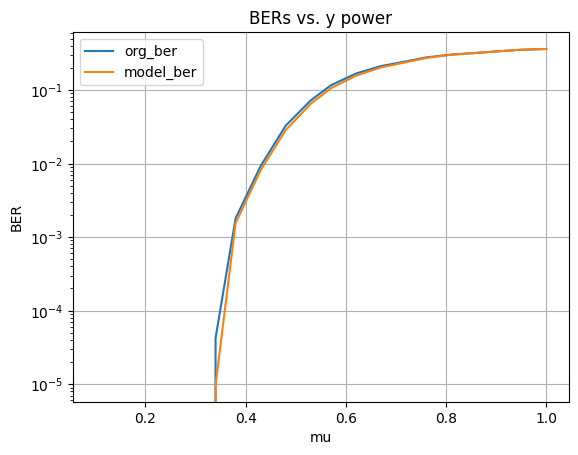

In [26]:
main_ds_path = '/data/yarcoh/thesis_data/data/datasets/c/noiseless_big/30000samples_20mu'
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/qam16_50x300/'

ma.plot_all_bers(base_path=main_ds_path, 
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=0.01, 
                 _tqdm=tqdm, 
                 verbose_level=0.5)
                    

In [29]:
# upload to wandb
ma.upload_all_bers_to_wandb(base_path=main_ds_path,
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=0.1, 
                 _tqdm=tqdm, 
                 verbose_level=0.5)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: yarden92. Use `wandb login --relogin` to force relogin


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.1 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.15 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.19 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.24 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.29 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.34 ----------------
org_ber=3.059895833333333e-05, model_ber=5.7942708333333335e-05, ber_improvement=-0.8936170212765959




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.38 ----------------
org_ber=0.00191796875, model_ber=0.0015608723958333334, ber_improvement=0.18618465716225385




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.43 ----------------
org_ber=0.0111015625, model_ber=0.009476236979166667, ber_improvement=0.1464051137696458




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.48 ----------------
org_ber=0.0319375, model_ber=0.027644856770833334, ber_improvement=0.13440761578604046




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.53 ----------------
org_ber=0.0712373046875, model_ber=0.0637685546875, ber_improvement=0.1048432423540378




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.57 ----------------
org_ber=0.118447265625, model_ber=0.10856868489583334, ber_improvement=0.08340066507269081




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.62 ----------------
org_ber=0.16478776041666668, model_ber=0.15420052083333333, ber_improvement=0.06424773027173537




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.67 ----------------
org_ber=0.21411686197916666, model_ber=0.20648860677083333, ber_improvement=0.03562659726012398




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.72 ----------------
org_ber=0.246822265625, model_ber=0.240880859375, ber_improvement=0.024071597572266238




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.76 ----------------
org_ber=0.2776692708333333, model_ber=0.27352115885416667, ber_improvement=0.014939038686987033




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.81 ----------------
org_ber=0.30490852864583334, model_ber=0.30199869791666667, ber_improvement=0.009543290711118773




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.86 ----------------
org_ber=0.32556998697916667, model_ber=0.3245904947916667, ber_improvement=0.0030085457095978085




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.91 ----------------
org_ber=0.33573014322916667, model_ber=0.33540266927083334, ber_improvement=0.0009754082704149478




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=0.95 ----------------
org_ber=0.35115397135416665, model_ber=0.35233170572916667, ber_improvement=-0.003353897352942588




  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]


----------------- BERs for mu=1.0 ----------------
org_ber=0.359287109375, model_ber=0.3608590494791667, ber_improvement=-0.004375164215886138




# THE END

In [ ]:
# # paper 1 model analyzer
# path_init = '../../data/test_models/mu-0.008__128ds__PaperNNforNFTmodel__3epochs'

# trainer_real = Trainer.load3(path_init + '__real')
# trainer_imag = Trainer.load3(path_init + '__imag')

# train_ds = SingleMuDataSet(trainer_real.train_dataset.data_dir_path,
#                            trainer_real.train_dataset.data_indices)
# val_ds = SingleMuDataSet(trainer_real.val_dataset.data_dir_path,
#                          trainer_real.val_dataset.data_indices)

# model = PaperNNforNFTwrapper(trainer_real.model, trainer_imag.model)

# trainer = Trainer(
#     train_dataset=train_ds,
#     val_dataset=val_ds,
#     model=model,
#     device=trainer_real.device,
#     batch_size=trainer_real.train_dataloader.batch_size,
#     l_metric=trainer_real.l_metric,
#     optim=trainer_real.optim,
#     params=trainer_real.params)

In [ ]:
# analyze on the whole dataset

# attach new dataset to trainer


In [ ]:
trainer.params

In [ ]:
ma = ModelAnalyzer(trainer)

In [ ]:
ma.plot_single_item(i=0)

In [ ]:
ma.plot_bers(_tqdm=tqdm)